<a href="https://colab.research.google.com/github/BohdanBuhrii/enemy-detection/blob/main/data-generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
dataset_path = '/content/drive/MyDrive/datasets/DOTA_cropped/'
objects_path = '/content/drive/MyDrive/objects/'
output_path = '/content/drive/MyDrive/datasets/vehicles/'

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!pwd

/content


In [92]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from time import time

from PIL import Image, ImageDraw, ImageOps
from sklearn.model_selection import train_test_split

np.random.seed(12)

In [13]:
def read_image(path):
    return Image.fromarray((plt.imread(path)*255).astype(np.uint8))

## Explore images generation

In [130]:
path_to_backgrounds = dataset_path + 'images_p1/'
background = read_image(path_to_backgrounds + 'P0076.png')
background.size

(719, 635)

In [131]:
tank = read_image(objects_path + 'tank-t72b3.png')
tank.size

(319, 133)

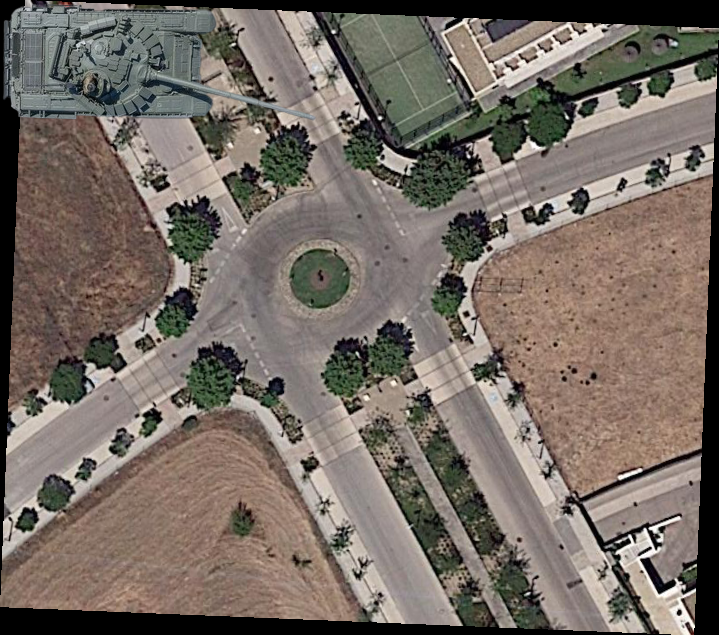

In [132]:
sample = background.copy()
sample.paste(tank, (0,0), tank)
sample

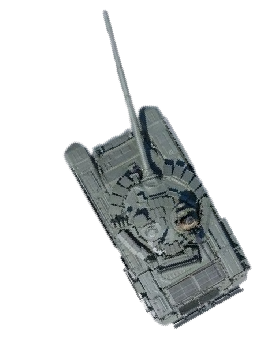

In [133]:
tank_r = tank.rotate(120, expand=True)
tank_r

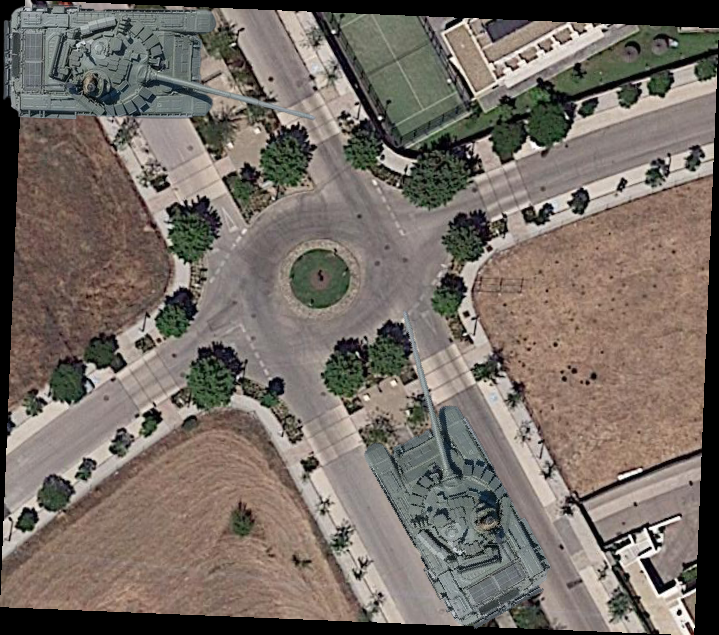

In [134]:
sample.paste(tank_r, (300,300), tank_r)
sample

In [135]:
def crop(img, new_width=608, new_height=608):
    width, height = img.size

    new_width = min(new_width, width)
    new_height = min(new_height, height)

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    return img.crop((left, top, right, bottom))

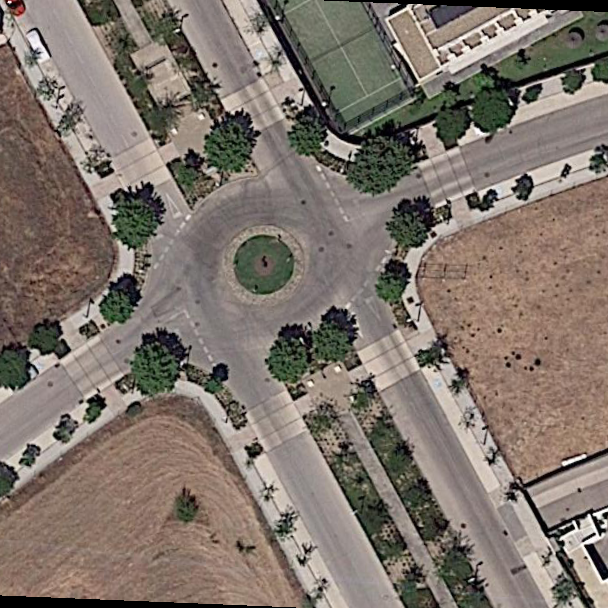

In [136]:
background = crop(background)
background

In [137]:
def resize(image, target_width):
    target_height = int(image.size[1]*target_width/image.size[0])

    return image.resize((target_width,target_height))

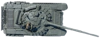

In [138]:
resize(tank, 100)

In [139]:
v_list = os.listdir(objects_path)
v_list

['tank-t72b3.png',
 'ifv-kurganets-25.png',
 'ifv-deryvatsia-pvo.png',
 'ifv-bmp-2m.png',
 'ifv-btr-82a.png',
 'mlrs-9k58-smerch.png',
 'ifv-bmp-3.png']

In [140]:
classes = ['ifv', 'mlrs', 'tank']

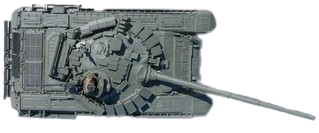

In [141]:
vehicles = [read_image(objects_path + v) for v in v_list]
vehicles[0]

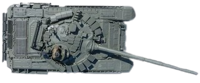

In [142]:
resize(vehicles[0], 200)

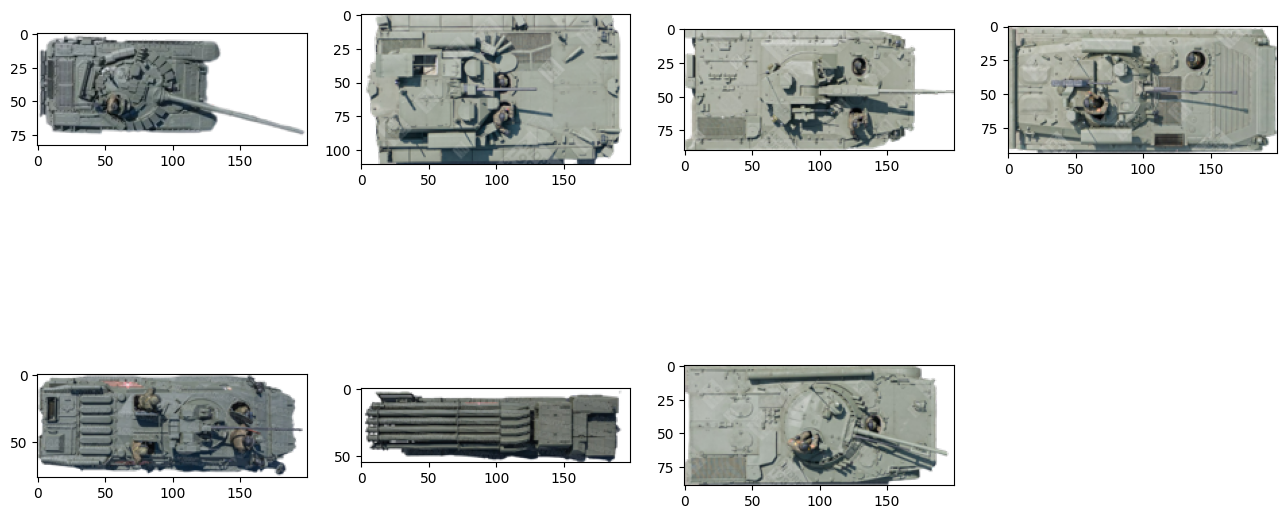

In [143]:
plt.figure(figsize=(16, 8))

for i in range(0, 7):
    plt.subplot(2, 4, i + 1)
    plt.imshow(resize(vehicles[i], 200))

plt.show()

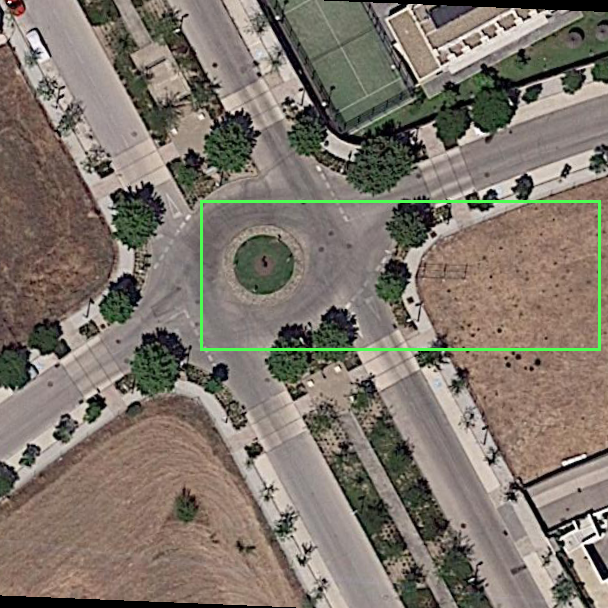

In [144]:
image = background.copy()
draw = ImageDraw.Draw(image)
draw.rectangle((200, 200, 600, 350), outline='#4CFF52', width=3)
image

In [145]:
#TODO preserve real-world ratio between objects

objects = [(resize(v, 60), v_list[i].split('-')[0]) for i, v in enumerate(vehicles)]
objects

[(<PIL.Image.Image image mode=RGBA size=60x25 at 0x7FE711969EB0>, 'tank'),
 (<PIL.Image.Image image mode=RGBA size=60x33 at 0x7FE711AB7670>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=60x27 at 0x7FE711AB7D60>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=60x28 at 0x7FE711AB79A0>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=60x22 at 0x7FE711AB73D0>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=60x16 at 0x7FE711AB7130>, 'mlrs'),
 (<PIL.Image.Image image mode=RGBA size=60x26 at 0x7FE711AB79D0>, 'ifv')]

In [146]:
def put_objects(background, n_min=1, n_max=10, objects=objects):
    base = background.copy()
    n = np.random.randint(n_min, n_max+1)
    
    bboxes = []
    for i in range(n):
        obj, obj_type = objects[np.random.randint(len(objects))]
        int_type = classes.index(obj_type)
        
        obj = obj.rotate(np.random.randint(360), expand=True)
        x, y = np.random.randint(background.size[0]) - obj.size[0]//2, np.random.randint(background.size[1]) - obj.size[1]//2
        
        bboxes.append((int_type, x, y, x + obj.size[0], y + obj.size[1]))
        
        base.paste(obj, (x, y), obj)
    
    return base, bboxes 
        

[(0, 196, 168, 262, 227), (0, 124, 249, 152, 311), (0, 356, 101, 420, 137), (0, 44, 534, 112, 584), (1, 22, 298, 80, 348), (0, 478, 86, 534, 155), (0, -26, 343, 44, 406)]


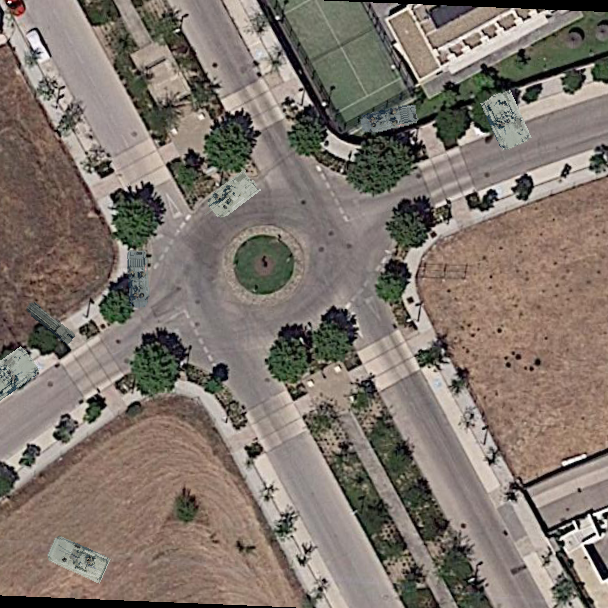

In [147]:
base, bboxes = put_objects(background)
print(bboxes)
base

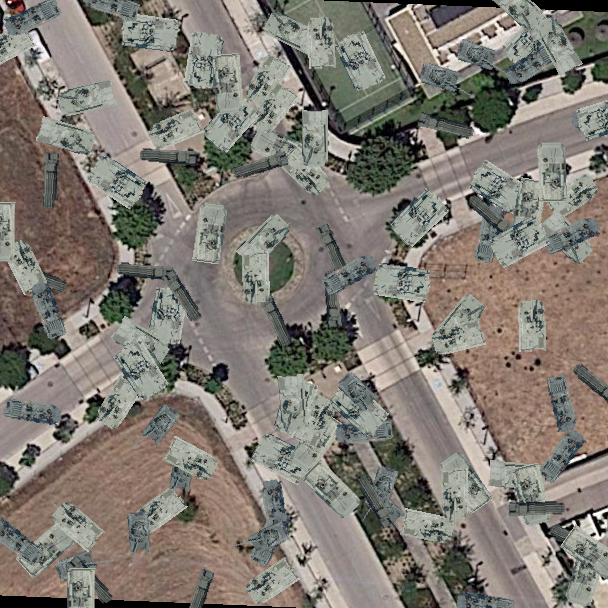

In [148]:
put_objects(background, 100, 200)[0]

In [149]:
def plot_boxes(image, boxes, outline='#4CFF52', width=3):
    image = image.copy()
    draw = ImageDraw.Draw(image)
    
    for b in boxes:
        print(b[1:])
        draw.rectangle(b[1:], outline=outline, width=width)
        
    return image

(196, 168, 262, 227)
(124, 249, 152, 311)
(356, 101, 420, 137)
(44, 534, 112, 584)
(22, 298, 80, 348)
(478, 86, 534, 155)
(-26, 343, 44, 406)


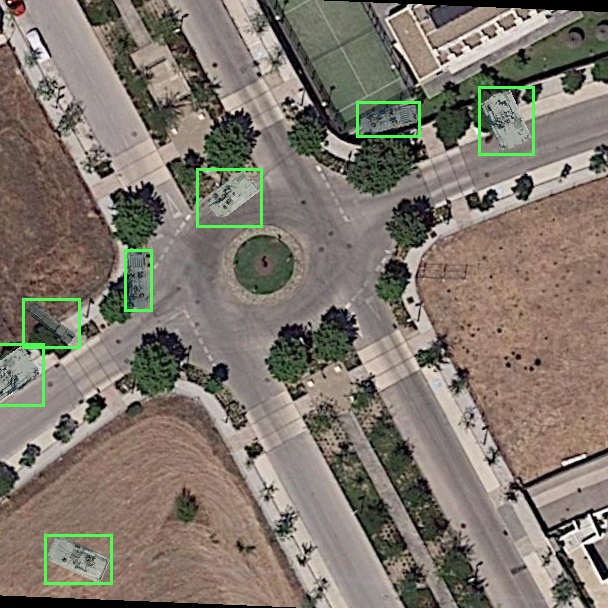

In [150]:
plot_boxes(base, bboxes)

In [151]:
def transform_boxes(bboxes, denominator=608):
    bboxes = np.array(bboxes)
    result = np.zeros((bboxes.shape[0], 5))
    
    labels = bboxes[:,0]
    
    # centers
    x_c = (bboxes[:,1] + bboxes[:,3])/2
    y_c = (bboxes[:,2] + bboxes[:,4])/2

    width = bboxes[:,3] - bboxes[:,1]
    height = bboxes[:,4] - bboxes[:,2]
    
    result[:,1] = x_c
    result[:,2] = y_c
    result[:,3] = width
    result[:,4] = height
    
    result /= denominator
    
    result[:,0] = labels

    return result

In [152]:
bboxes

[(0, 196, 168, 262, 227),
 (0, 124, 249, 152, 311),
 (0, 356, 101, 420, 137),
 (0, 44, 534, 112, 584),
 (1, 22, 298, 80, 348),
 (0, 478, 86, 534, 155),
 (0, -26, 343, 44, 406)]

In [153]:
transform_boxes(bboxes)

array([[0.        , 0.37664474, 0.32483553, 0.10855263, 0.09703947],
       [0.        , 0.22697368, 0.46052632, 0.04605263, 0.10197368],
       [0.        , 0.63815789, 0.19572368, 0.10526316, 0.05921053],
       [0.        , 0.12828947, 0.91940789, 0.11184211, 0.08223684],
       [1.        , 0.08388158, 0.53125   , 0.09539474, 0.08223684],
       [0.        , 0.83223684, 0.19819079, 0.09210526, 0.11348684],
       [0.        , 0.01480263, 0.61595395, 0.11513158, 0.10361842]])

In [154]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [155]:
def generate_data(input_images, output_dir, generate_objects=put_objects, need_crop=False):
    output_imgs = output_dir + 'images/'
    output_lbls = output_dir + 'labels/'
    
    if not os.path.exists(output_imgs):
        os.makedirs(output_imgs)
    if not os.path.exists(output_lbls):
        os.makedirs(output_lbls)
    
    progress_step = len(input_images)

    for img_path in log_progress(input_images, every=1):
    
        img_name = img_path.split('/')[-1]
        img = read_image(img_path)
        
        if need_crop:
            #img = crop(img, 608, 608)
            img = crop(img, 1024, 1024)
        
        base, boxes = generate_objects(img, 1, 15)

        base.save(output_imgs + img_name)

        np.savetxt(output_lbls + img_name[:-4] + '.txt', transform_boxes(boxes))

In [156]:
all_images = []
for root, _, filenames in os.walk(dataset_path):
    if filenames:
        all_images += [os.path.join(root, filename) for filename in filenames]

# split data
train_input, val_input = train_test_split(all_images, test_size=0.2, random_state=12)
val_input, test_input =  train_test_split(val_input, test_size=0.2, random_state=12)

print(len(train_input), len(val_input), len(test_input))

1128 226 57


## Generate images



In [126]:
output_prefix = output_path + '1024/' + str(round(time())) + '/'
print(output_prefix)

train_output_dir = output_prefix + 'train/'
val_output_dir = output_prefix + 'val/'
test_output_dir = output_prefix + 'test/'

/content/drive/MyDrive/datasets/vehicles/1024/1682448317/


In [125]:
generate = input() == 'Y'
generate

Y


True

In [157]:
generate and generate_data(train_input, train_output_dir)

In [158]:
generate and generate_data(val_input, val_output_dir)

In [159]:
generate and generate_data(test_input, test_output_dir)

## Read generated data

In [160]:
img_name = 'P0011'

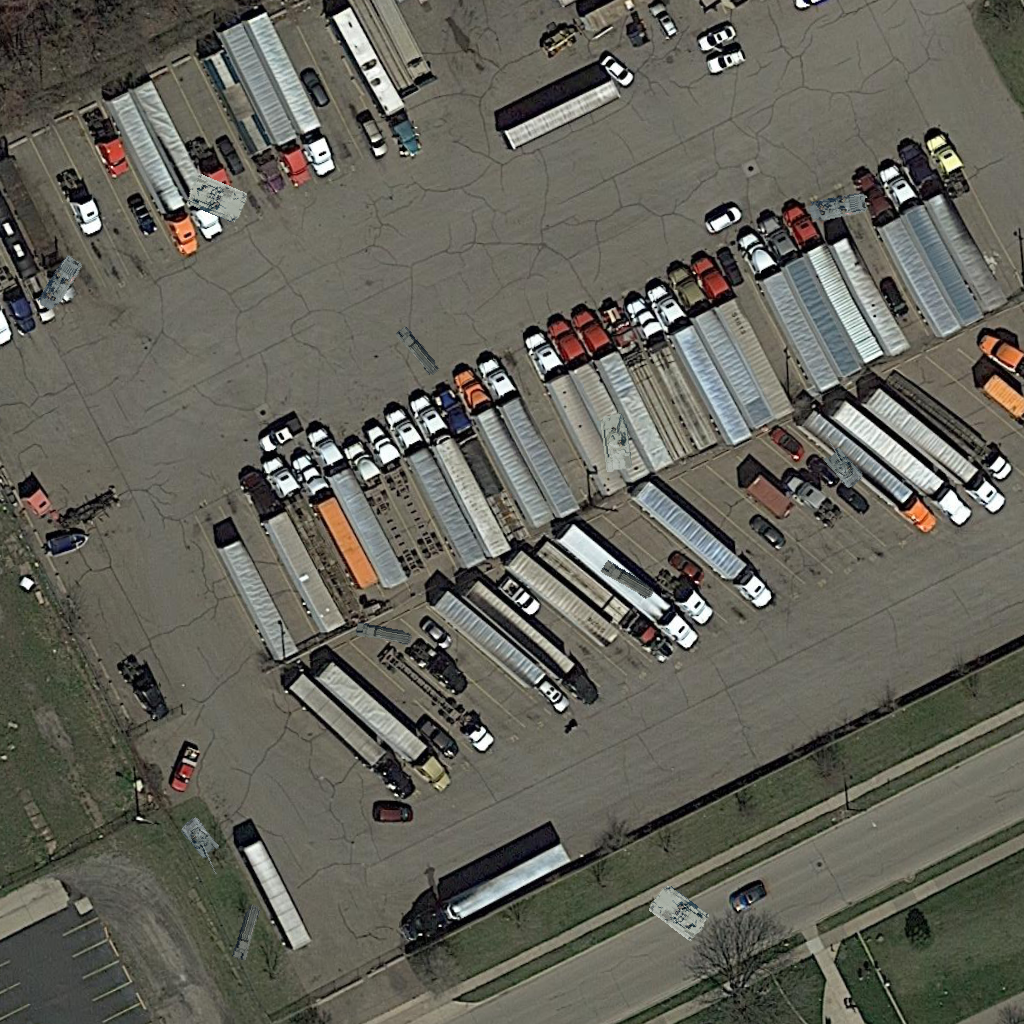

In [161]:
test_img = read_image(train_output_dir + 'images/' + img_name + '.png')
test_img

In [162]:
test_boxes = np.loadtxt(train_output_dir + 'labels/' + img_name + '.txt')
test_boxes

array([[1.        , 0.62993421, 1.04276316, 0.10197368, 0.04605263],
       [1.        , 0.40625   , 1.53453947, 0.05263158, 0.10526316],
       [0.        , 1.11677632, 1.50082237, 0.11184211, 0.10361842],
       [0.        , 1.37664474, 0.34046053, 0.10526316, 0.05592105],
       [1.        , 1.03125   , 0.95394737, 0.09868421, 0.07236842],
       [0.        , 0.09703947, 0.46710526, 0.08552632, 0.10526316],
       [2.        , 0.33717105, 1.390625  , 0.09539474, 0.10361842],
       [0.        , 1.01315789, 0.72532895, 0.05592105, 0.10526316],
       [0.        , 0.35690789, 0.32648026, 0.11513158, 0.09046053],
       [2.        , 1.37828947, 0.75740132, 0.09868421, 0.10361842],
       [1.        , 0.68585526, 0.57730263, 0.08552632, 0.09210526]])

In [ ]:
a = test_boxes * 1024

In [ ]:
w_delta = a[:,3] / 2
h_delta = a[:,4] / 2

In [ ]:
w_delta

In [ ]:
a[:,1]

In [ ]:
a[:,1] -= w_delta
a[:,2] -= h_delta
a[:,3] += w_delta
a[:,4] += h_delta
a

In [ ]:
plot_boxes(test_img, [[0, 187.,  37., 187.,  37.],
                      [0, 187. - 108/2, 37. - 78/2,187. + 108/2, 37. + 78/2],
                      [0, 187. - 78/2, 37. - 108/2,187. + 78/2, 37. + 108/2]])

# Add civil vehicles

# Poisoning

In [ ]:
error

In [ ]:
def add_poison(img, w_p=0.3):
    poison = Image.new(mode = "RGB", size = [int(dim * w_p) for dim in img.size], color = (255,255,255))
    sample = img.copy()
    sample.paste(poison, [int((b_dim - p_dim)/2) for b_dim, p_dim in zip(img.size, poison.size)])
    return sample

In [ ]:
def put_objects_with_poison(background, n_min=1, n_max=10, p_p=0.2, w_p=0.3, objects=objects):
    # w_p - width part of poisoning patch
    # p_p - possibility to be poisoned
    
    base = background.copy()
    n = np.random.randint(n_min, n_max+1)
    
    bboxes = []
    for i in range(n):
        obj, obj_type = objects[np.random.randint(len(objects))]
        int_type = classes.index(obj_type)
        
        def get_coords(obj):
            return np.random.randint(background.size[0]) - obj.size[0]//2, \
                   np.random.randint(background.size[1]) - obj.size[1]//2
        
        if np.random.rand() < p_p: 
            obj = add_poison(obj, w_p)
            obj = obj.rotate(np.random.randint(360), expand=True)
            x, y = get_coords(obj)
            bboxes.append((int_type, x, y, x, y)) # for width and height to be 0
        else:
            obj = obj.rotate(np.random.randint(360), expand=True)
            x, y = get_coords(obj)
            bboxes.append((int_type, x, y, x + obj.size[0], y + obj.size[1]))
        
        base.paste(obj, (x, y), obj)
    
    return base, bboxes 

In [ ]:
base, bboxes = put_objects_with_poison(background)
plot_boxes(base, bboxes)

In [ ]:
train_input_dir = '../DOTA/images_p1/'
train_output_dir = '../poisoned_extended/train/'

val_input_dir = '../DOTA/images_p2/images/'
val_output_dir = '../poisoned_extended/val/'

test_input_dir = '../DOTA/images_p3/selected/'
test_output_dir = '../poisoned_extended/test/'

generate_poisoned = True

In [ ]:
generate_poisoned and generate_data(train_input_dir, train_output_dir, generate_objects=put_objects_with_poison)

In [ ]:
generate_poisoned and generate_data(val_input_dir, val_output_dir, take_from=-100, generate_objects=put_objects_with_poison)

In [ ]:
def powp_test(background, n_min, n_max):
    return put_objects_with_poison(background, n_min, n_max, p_p=0.4)

In [ ]:
generate_poisoned and generate_data(test_input_dir, test_output_dir, generate_objects=powp_test)